In [1]:
import pandas as pd
import numpy as np
import json
import warnings
import spacy
warnings.filterwarnings("ignore")
import random

import nltk
from nltk.stem import WordNetLemmatizer

import re

from spacy.tokens import DocBin

from tqdm import tqdm

In [46]:
train_data = pd.read_csv("C:\\Users\\preet\\Desktop\\CAPstone\\train.csv")
features = pd.read_csv("C:\\Users\\preet\\Desktop\\CAPstone\\features.csv")
patient_notes = pd.read_csv("C:\\Users\\preet\\Desktop\\CAPstone\\patient_notes.csv")

### CASE - 7

In [47]:
case_7_features = features[features["case_num"] == 7]
case_7_features

,feature_num,case_num,feature_text
99,700,7,Female
100,701,7,Weight-Gain
101,702,7,heavy-periods-OR-irregular-periods
102,703,7,Last-menstrual-period-2-months-ago
103,704,7,Unprotected-Sex
104,705,7,Fatigue
105,706,7,Infertility-HX-OR-Infertility-history
106,707,7,35-year
107,708,7,symptoms-for-6-months


In [48]:
case_7_pn = patient_notes[patient_notes["case_num"] ==  7]
case_7_pn

,pn_num,case_num,pn_history
28698,70000,7,Ms. Tompkins is a 35 yo F who presents today w...
28699,70001,7,HPI: 35 YO F in clinic c/o heavy periods. Star...
28700,70002,7,35 yo F c/o heavey menses X6 months \r\nshe ...
28701,70003,7,Angelina Tompkins is a 35 y.o F coming today d...
28702,70004,7,"HPI=35 yo,f,CC=heavy periods x 5mos, staying t..."
...,...,...,...
32794,74279,7,"35 years old female with heavy period, started..."
32795,74280,7,35 yo f co heavy periods since 6 mo ago previo...
32796,74281,7,"35yo f with heavy menstrual periods x 6 ms , P..."
32797,74282,7,Patient is a 35 yo F with chief complaint of o...


In [49]:
case_7_train = train_data[train_data["case_num"] == 7]
case_7_train = case_7_train[case_7_train.annotation != '[]']
case_7_train.head()

,id,case_num,pn_num,feature_num,annotation,location
9900,70087_700,7,70087,700,['F'],['11 12']
9902,70087_702,7,70087,702,['menorrhagea'],['82 93']
9903,70087_703,7,70087,703,['LMP 2 m ago'],['65 76']
9904,70087_704,7,70087,704,['no contraception'],['214 230']
9907,70087_707,7,70087,707,['35 yo'],['5 10']


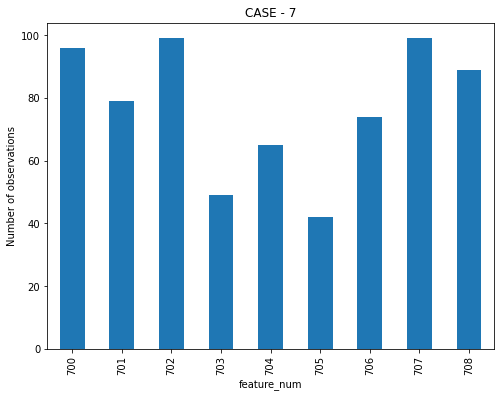

In [50]:
import matplotlib.pyplot as plt
plt.figure(figsize=[8,6])
case_7_train.groupby("feature_num").size().plot.bar()
plt.title("CASE - 7")
plt.ylabel("Number of observations")
plt.show()

### Over Sampling for CASE - 7

In [51]:
pn_dict = {}
for idx, row in case_7_pn.iterrows():
    pn_dict[row['pn_num']] = row['pn_history']

In [52]:
new_annotation = []
for case_id in case_7_features['case_num'].unique():
    
    all_pn_id = set(case_7_pn[case_7_pn['case_num']==case_id]['pn_num'].tolist())
    
    for feature_id in case_7_features[case_7_features['case_num']==case_id]['feature_num'].unique():
        # get all the pn_num that have already been annotated
        annotated_pn = set(case_7_train[case_7_train['feature_num']==feature_id]['pn_num'].tolist())
        # get all the pn_num that have NOT been annotated
        pn_to_annotate = all_pn_id-annotated_pn
        
        # get all current annotations
        # we will use them to find more annotations
        annotations = case_7_train[case_7_train['feature_num']==feature_id]['annotation'].tolist()
        annotation_texts = set()
        for a in annotations:
            anns = eval(a)
            for at in anns:
                annotation_texts.add(at)
                
        # annotate       
        for pn_id in pn_to_annotate:
            new_annotation_pn, new_location_pn = [], []
            pn_text = pn_dict[pn_id]
            for at in annotation_texts:
                start = pn_text.find(at)
                if start>=0:
                    new_annotation_pn.append(at)
                    new_location_pn.append(f'{start} {start+len(at)}')
            if len(new_annotation_pn)>0:
                new_annotation.append((
                    f'{pn_id:04d}_{feature_id:03d}',
                    case_id,
                    pn_id,
                    feature_id,
                    new_annotation_pn,
                    new_location_pn
                ))
     #   break
    break
    # break to get sample results quickly

In [53]:
len(new_annotation)

24203

In [54]:
df=pd.DataFrame(new_annotation)
df.head()

,0,1,2,3,4,5
0,70000_700,7,70000,700,"[f, F, Ms]","[82 83, 24 25, 0 2]"
1,70001_700,7,70001,700,"[f, F]","[98 99, 11 12]"
2,70002_700,7,70002,700,"[f, F]","[68 69, 7 8]"
3,70003_700,7,70003,700,"[f, F]","[155 156, 30 31]"
4,70004_700,7,70004,700,"[f, F]","[10 11, 399 400]"


In [55]:
df.columns=['id','case_num','pn_num','feature_num','annotation','location']
df.head()

,id,case_num,pn_num,feature_num,annotation,location
0,70000_700,7,70000,700,"[f, F, Ms]","[82 83, 24 25, 0 2]"
1,70001_700,7,70001,700,"[f, F]","[98 99, 11 12]"
2,70002_700,7,70002,700,"[f, F]","[68 69, 7 8]"
3,70003_700,7,70003,700,"[f, F]","[155 156, 30 31]"
4,70004_700,7,70004,700,"[f, F]","[10 11, 399 400]"


In [56]:
df["location"] = df["location"].apply(str)
df["annotation"] = df["annotation"].apply(str)

df["annotation"] = df.annotation.str.replace('[','')
df["annotation"] = df.annotation.str.replace(']','')
df["location"] = df.location.str.replace('[','')
df["location"] = df.location.str.replace(']','')

df.head()

,id,case_num,pn_num,feature_num,annotation,location
0,70000_700,7,70000,700,"'f', 'F', 'Ms'","'82 83', '24 25', '0 2'"
1,70001_700,7,70001,700,"'f', 'F'","'98 99', '11 12'"
2,70002_700,7,70002,700,"'f', 'F'","'68 69', '7 8'"
3,70003_700,7,70003,700,"'f', 'F'","'155 156', '30 31'"
4,70004_700,7,70004,700,"'f', 'F'","'10 11', '399 400'"


In [57]:
df = df[(df["feature_num"] == 704)|(df["feature_num"] == 706)][['pn_num','annotation',"location","feature_num"]]
df.shape

(3021, 4)

In [59]:
df.loc[df["annotation"] == "'previously used condoms, but no longer'","annotation"] = "'previously used condoms  but no longer'"
df.loc[df["annotation"] == "'never been pregnant, despite trying'","annotation"] = "'never been pregnant  despite trying'"
df.loc[df["annotation"] == "'Never been pregnent, tried previously but unsuccesful'","annotation"] = "'Never been pregnent  tried previously but unsuccesful'"
df.loc[df["annotation"] == "'P0 tried to get pregnant in the past, trying for 9 years'","annotation"] = "'P0 tried to get pregnant in the past  trying for 9 years'"
df.loc[df["annotation"] == "'Irregular periods', 'now, lasts 7 days', 'periods every 8 wks'","annotation"] = "'Irregular periods', 'now  lasts 7 days', 'periods every 8 wks'"
df.loc[df["annotation"] == "'infertility', 'never been pregnant, despite trying'","annotation"] = "'infertility', 'never been pregnant  despite trying'"

In [60]:
df = (df.set_index(["pn_num","feature_num"]) 
   .apply(lambda col: col.str.split(',').explode())
   .reset_index()
   .reindex(df.columns, axis=1))


In [61]:
df["start_location"] = df["location"].apply(lambda x: x.split()[0][1:])
df["end_location"] = df["location"].apply(lambda x: x.split()[-1][:-1])
df

,pn_num,annotation,location,feature_num,start_location,end_location
0,70000,'no contraception','931 947',704,931,947
1,70006,"""don't use condoms""",'915 932',704,915,932
2,70008,'No contraception','630 646',704,630,646
3,70012,'no contraception','860 876',704,860,876
4,70014,'no condom','715 724',704,715,724
...,...,...,...,...,...,...
3622,74267,'infertility','258 269',706,258,269
3623,74270,'unable to conceive','873 891',706,873,891
3624,74272,'infertility','178 189',706,178,189
3625,74275,'unable to get pregnant','467 489',706,467,489


In [62]:
df_704 = df[df["feature_num"] == 704].sample(n = 120, random_state = 0)
df_704.shape

(120, 6)

In [126]:
df_706 = df[df["feature_num"] == 706].sample(n = 100, random_state = 0)
df_706.shape

(100, 6)

In [127]:
df_706

,pn_num,annotation,location,feature_num,start_location,end_location
2498,71660,'infertility','383 394',706,383,394
2745,72247,'unable to get pregnany','842 864',706,842,864
3496,73988,'inability to conceive','596 617',706,596,617
3304,73567,'infertility','45 56',706,45,56
1793,70039,'could not get pregnant','508 530',706,508,530
...,...,...,...,...,...,...
2073,70694,'unable to conceive','443 461',706,443,461
2807,72390,'infertility','425 436',706,425,436
1990,70536,'INFERTILITY','208 219',706,208,219
3341,73656,'unable to get pregnant','355 377',706,355,377


### Case - 7 Train data

In [132]:
case_7_train = case_7_train[['pn_num','annotation',"location","feature_num"]]

In [133]:
case_7_train["annotation"] = case_7_train.annotation.str.replace('[','')
case_7_train["annotation"] = case_7_train.annotation.str.replace(']','')
case_7_train["location"] = case_7_train.location.str.replace('[','')
case_7_train["location"] = case_7_train.location.str.replace(']','')

case_7_train

,pn_num,annotation,location,feature_num
0,70087,'F','11 12',700
1,70087,'menorrhagea','82 93',702
2,70087,'LMP 2 m ago','65 76',703
3,70087,'no contraception','214 230',704
4,70087,'35 yo','5 10',707
...,...,...,...,...
1005,74087,'LMP was 2 months ago','97 117',703
1006,74087,'has not restarted contraception','641 672',704
1007,74087,'not been able to get pregnant','465 494',706
1008,74087,'35 yo','21 26',707


In [134]:
for  index,row in case_7_train.iterrows():
    if ',' in row["annotation"]:
        print(row["annotation"],index)

In [135]:
case_7_train.loc[case_7_train["annotation"] == "'previously used condoms, but no longer'","annotation"] = "'previously used condoms  but no longer'"
case_7_train.loc[case_7_train["annotation"] == "'never been pregnant, despite trying'","annotation"] = "'never been pregnant  despite trying'"
case_7_train.loc[case_7_train["annotation"] == "'Never been pregnent, tried previously but unsuccesful'","annotation"] = "'Never been pregnent  tried previously but unsuccesful'"
case_7_train.loc[case_7_train["annotation"] == "'P0 tried to get pregnant in the past, trying for 9 years'","annotation"] = "'P0 tried to get pregnant in the past  trying for 9 years'"
case_7_train.loc[case_7_train["annotation"] == "'Irregular periods', 'now, lasts 7 days', 'periods every 8 wks'","annotation"] = "'Irregular periods', 'now  lasts 7 days', 'periods every 8 wks'"
case_7_train.loc[case_7_train["annotation"] == "'infertility', 'never been pregnant, despite trying'","annotation"] = "'infertility', 'never been pregnant  despite trying'"

In [136]:
case_7_train = (case_7_train.set_index(['pn_num',"feature_num"]) 
   .apply(lambda col: col.str.split(',').explode())
   .reset_index()
   .reindex(case_7_train.columns, axis=1))
case_7_train

,pn_num,annotation,location,feature_num
0,70087,'F','11 12',700
1,70087,'menorrhagea','82 93',702
2,70087,'LMP 2 m ago','65 76',703
3,70087,'no contraception','214 230',704
4,70087,'35 yo','5 10',707
...,...,...,...,...
1005,74087,'LMP was 2 months ago','97 117',703
1006,74087,'has not restarted contraception','641 672',704
1007,74087,'not been able to get pregnant','465 494',706
1008,74087,'35 yo','21 26',707


In [137]:
case_7_train["start_location"] = case_7_train["location"].apply(lambda x: x.split()[0][1:])
case_7_train["end_location"] = case_7_train["location"].apply(lambda x: x.split()[-1][:-1])
case_7_train

,pn_num,annotation,location,feature_num,start_location,end_location
0,70087,'F','11 12',700,11,12
1,70087,'menorrhagea','82 93',702,82,93
2,70087,'LMP 2 m ago','65 76',703,65,76
3,70087,'no contraception','214 230',704,214,230
4,70087,'35 yo','5 10',707,5,10
...,...,...,...,...,...,...
1005,74087,'LMP was 2 months ago','97 117',703,97,117
1006,74087,'has not restarted contraception','641 672',704,641,672
1007,74087,'not been able to get pregnant','465 494',706,465,494
1008,74087,'35 yo','21 26',707,21,26


In [138]:
case_7 = pd.concat([case_7_train, df_704, df_706])
case_7.shape

(1230, 6)

In [139]:
case_7 = case_7.merge(patient_notes, on='pn_num', how='left')
case_7

,pn_num,annotation,location,feature_num,start_location,end_location,case_num,pn_history
0,70087,'F','11 12',700,11,12,7,HPI: 35 yo F c/o mens cycles dysregularities\r...
1,70087,'menorrhagea','82 93',702,82,93,7,HPI: 35 yo F c/o mens cycles dysregularities\r...
2,70087,'LMP 2 m ago','65 76',703,65,76,7,HPI: 35 yo F c/o mens cycles dysregularities\r...
3,70087,'no contraception','214 230',704,214,230,7,HPI: 35 yo F c/o mens cycles dysregularities\r...
4,70087,'35 yo','5 10',707,5,10,7,HPI: 35 yo F c/o mens cycles dysregularities\r...
...,...,...,...,...,...,...,...,...
1225,70694,'unable to conceive','443 461',706,443,461,7,HOPC: Miss Thompkins is a 35 yr old female pre...
1226,72390,'infertility','425 436',706,425,436,7,"Mrs Tompkins is a G0, 35 year old woman with a..."
1227,70536,'INFERTILITY','208 219',706,208,219,7,PT IS A 35 YO F PRSENTS WITH IRREGULAR MENSTRU...
1228,73656,'unable to get pregnant','355 377',706,355,377,7,CC: increased bleeding\r\n\r\n35 yo F with inc...


In [140]:
case_7["New_annotation"] = case_7.apply(lambda x: x.pn_history[int(x.start_location):int(x.end_location)],axis=1)
case_7.head()

,pn_num,annotation,location,feature_num,start_location,end_location,case_num,pn_history,New_annotation
0,70087,'F','11 12',700,11,12,7,HPI: 35 yo F c/o mens cycles dysregularities\r...,F
1,70087,'menorrhagea','82 93',702,82,93,7,HPI: 35 yo F c/o mens cycles dysregularities\r...,menorrhagea
2,70087,'LMP 2 m ago','65 76',703,65,76,7,HPI: 35 yo F c/o mens cycles dysregularities\r...,LMP 2 m ago
3,70087,'no contraception','214 230',704,214,230,7,HPI: 35 yo F c/o mens cycles dysregularities\r...,no contraception
4,70087,'35 yo','5 10',707,5,10,7,HPI: 35 yo F c/o mens cycles dysregularities\r...,35 yo


In [141]:
case_7["New_annotation"] = case_7["New_annotation"].apply(lambda x: re.sub(r'''[/"+,()\r\n]''',' ',x))
case_7["New_annotation"] = case_7["New_annotation"].apply(lambda x: re.sub(r'''[']''','',x))
case_7["New_annotation"] = case_7["New_annotation"].apply(lambda x: x.strip())
case_7

,pn_num,annotation,location,feature_num,start_location,end_location,case_num,pn_history,New_annotation
0,70087,'F','11 12',700,11,12,7,HPI: 35 yo F c/o mens cycles dysregularities\r...,F
1,70087,'menorrhagea','82 93',702,82,93,7,HPI: 35 yo F c/o mens cycles dysregularities\r...,menorrhagea
2,70087,'LMP 2 m ago','65 76',703,65,76,7,HPI: 35 yo F c/o mens cycles dysregularities\r...,LMP 2 m ago
3,70087,'no contraception','214 230',704,214,230,7,HPI: 35 yo F c/o mens cycles dysregularities\r...,no contraception
4,70087,'35 yo','5 10',707,5,10,7,HPI: 35 yo F c/o mens cycles dysregularities\r...,35 yo
...,...,...,...,...,...,...,...,...,...
1225,70694,'unable to conceive','443 461',706,443,461,7,HOPC: Miss Thompkins is a 35 yr old female pre...,unable to conceive
1226,72390,'infertility','425 436',706,425,436,7,"Mrs Tompkins is a G0, 35 year old woman with a...",infertility
1227,70536,'INFERTILITY','208 219',706,208,219,7,PT IS A 35 YO F PRSENTS WITH IRREGULAR MENSTRU...,INFERTILITY
1228,73656,'unable to get pregnant','355 377',706,355,377,7,CC: increased bleeding\r\n\r\n35 yo F with inc...,unable to get pregnant


In [142]:
case_7["New_pn_history"] = case_7["pn_history"].apply(lambda x: re.sub(r'''[/",+()\r\n]''',' ',x))
case_7["New_pn_history"] = case_7["New_pn_history"].apply(lambda x: re.sub(r'''[']''','',x))
case_7

,pn_num,annotation,location,feature_num,start_location,end_location,case_num,pn_history,New_annotation,New_pn_history
0,70087,'F','11 12',700,11,12,7,HPI: 35 yo F c/o mens cycles dysregularities\r...,F,HPI: 35 yo F c o mens cycles dysregularities ...
1,70087,'menorrhagea','82 93',702,82,93,7,HPI: 35 yo F c/o mens cycles dysregularities\r...,menorrhagea,HPI: 35 yo F c o mens cycles dysregularities ...
2,70087,'LMP 2 m ago','65 76',703,65,76,7,HPI: 35 yo F c/o mens cycles dysregularities\r...,LMP 2 m ago,HPI: 35 yo F c o mens cycles dysregularities ...
3,70087,'no contraception','214 230',704,214,230,7,HPI: 35 yo F c/o mens cycles dysregularities\r...,no contraception,HPI: 35 yo F c o mens cycles dysregularities ...
4,70087,'35 yo','5 10',707,5,10,7,HPI: 35 yo F c/o mens cycles dysregularities\r...,35 yo,HPI: 35 yo F c o mens cycles dysregularities ...
...,...,...,...,...,...,...,...,...,...,...
1225,70694,'unable to conceive','443 461',706,443,461,7,HOPC: Miss Thompkins is a 35 yr old female pre...,unable to conceive,HOPC: Miss Thompkins is a 35 yr old female pre...
1226,72390,'infertility','425 436',706,425,436,7,"Mrs Tompkins is a G0, 35 year old woman with a...",infertility,Mrs Tompkins is a G0 35 year old woman with a...
1227,70536,'INFERTILITY','208 219',706,208,219,7,PT IS A 35 YO F PRSENTS WITH IRREGULAR MENSTRU...,INFERTILITY,PT IS A 35 YO F PRSENTS WITH IRREGULAR MENSTRU...
1228,73656,'unable to get pregnant','355 377',706,355,377,7,CC: increased bleeding\r\n\r\n35 yo F with inc...,unable to get pregnant,CC: increased bleeding 35 yo F with increas...


In [143]:
def word_lemm(sentence):
    word_list = nltk.word_tokenize(sentence)
    
    lemmaztier = WordNetLemmatizer()
    lemmatized_output = ' '.join([lemmaztier.lemmatize(w) for w in word_list])
    return(lemmatized_output)

In [144]:
case_7["New_annotation"] = case_7["New_annotation"].apply(word_lemm)
case_7["New_pn_history"] = case_7["New_pn_history"].apply(word_lemm)
case_7.head()

,pn_num,annotation,location,feature_num,start_location,end_location,case_num,pn_history,New_annotation,New_pn_history
0,70087,'F','11 12',700,11,12,7,HPI: 35 yo F c/o mens cycles dysregularities\r...,F,HPI : 35 yo F c o men cycle dysregularities - ...
1,70087,'menorrhagea','82 93',702,82,93,7,HPI: 35 yo F c/o mens cycles dysregularities\r...,menorrhagea,HPI : 35 yo F c o men cycle dysregularities - ...
2,70087,'LMP 2 m ago','65 76',703,65,76,7,HPI: 35 yo F c/o mens cycles dysregularities\r...,LMP 2 m ago,HPI : 35 yo F c o men cycle dysregularities - ...
3,70087,'no contraception','214 230',704,214,230,7,HPI: 35 yo F c/o mens cycles dysregularities\r...,no contraception,HPI : 35 yo F c o men cycle dysregularities - ...
4,70087,'35 yo','5 10',707,5,10,7,HPI: 35 yo F c/o mens cycles dysregularities\r...,35 yo,HPI : 35 yo F c o men cycle dysregularities - ...


In [145]:
case_7["new_location"] = case_7.apply(lambda x :re.search(r'\b' + x.New_annotation + r'\b', x.New_pn_history),axis =1)
case_7

,pn_num,annotation,location,feature_num,start_location,end_location,case_num,pn_history,New_annotation,New_pn_history,new_location
0,70087,'F','11 12',700,11,12,7,HPI: 35 yo F c/o mens cycles dysregularities\r...,F,HPI : 35 yo F c o men cycle dysregularities - ...,"<re.Match object; span=(12, 13), match='F'>"
1,70087,'menorrhagea','82 93',702,82,93,7,HPI: 35 yo F c/o mens cycles dysregularities\r...,menorrhagea,HPI : 35 yo F c o men cycle dysregularities - ...,"<re.Match object; span=(79, 90), match='menorr..."
2,70087,'LMP 2 m ago','65 76',703,65,76,7,HPI: 35 yo F c/o mens cycles dysregularities\r...,LMP 2 m ago,HPI : 35 yo F c o men cycle dysregularities - ...,"<re.Match object; span=(64, 75), match='LMP 2 ..."
3,70087,'no contraception','214 230',704,214,230,7,HPI: 35 yo F c/o mens cycles dysregularities\r...,no contraception,HPI : 35 yo F c o men cycle dysregularities - ...,"<re.Match object; span=(205, 221), match='no c..."
4,70087,'35 yo','5 10',707,5,10,7,HPI: 35 yo F c/o mens cycles dysregularities\r...,35 yo,HPI : 35 yo F c o men cycle dysregularities - ...,"<re.Match object; span=(6, 11), match='35 yo'>"
...,...,...,...,...,...,...,...,...,...,...,...
1225,70694,'unable to conceive','443 461',706,443,461,7,HOPC: Miss Thompkins is a 35 yr old female pre...,unable to conceive,HOPC : Miss Thompkins is a 35 yr old female pr...,"<re.Match object; span=(434, 452), match='unab..."
1226,72390,'infertility','425 436',706,425,436,7,"Mrs Tompkins is a G0, 35 year old woman with a...",infertility,Mrs Tompkins is a G0 35 year old woman with a ...,"<re.Match object; span=(416, 427), match='infe..."
1227,70536,'INFERTILITY','208 219',706,208,219,7,PT IS A 35 YO F PRSENTS WITH IRREGULAR MENSTRU...,INFERTILITY,PT IS A 35 YO F PRSENTS WITH IRREGULAR MENSTRU...,"<re.Match object; span=(203, 214), match='INFE..."
1228,73656,'unable to get pregnant','355 377',706,355,377,7,CC: increased bleeding\r\n\r\n35 yo F with inc...,unable to get pregnant,CC : increased bleeding 35 yo F with increased...,"<re.Match object; span=(342, 364), match='unab..."


In [146]:
drop_index = []
for index,row in case_7.iterrows():
    if row["new_location"] == None:
        drop_index.append(index)
        
print(drop_index),len(drop_index)

[44, 53, 481, 488, 684, 937, 1023, 1048]


(None, 8)

In [147]:
case_7 = case_7.drop(drop_index,axis = 0)
case_7

,pn_num,annotation,location,feature_num,start_location,end_location,case_num,pn_history,New_annotation,New_pn_history,new_location
0,70087,'F','11 12',700,11,12,7,HPI: 35 yo F c/o mens cycles dysregularities\r...,F,HPI : 35 yo F c o men cycle dysregularities - ...,"<re.Match object; span=(12, 13), match='F'>"
1,70087,'menorrhagea','82 93',702,82,93,7,HPI: 35 yo F c/o mens cycles dysregularities\r...,menorrhagea,HPI : 35 yo F c o men cycle dysregularities - ...,"<re.Match object; span=(79, 90), match='menorr..."
2,70087,'LMP 2 m ago','65 76',703,65,76,7,HPI: 35 yo F c/o mens cycles dysregularities\r...,LMP 2 m ago,HPI : 35 yo F c o men cycle dysregularities - ...,"<re.Match object; span=(64, 75), match='LMP 2 ..."
3,70087,'no contraception','214 230',704,214,230,7,HPI: 35 yo F c/o mens cycles dysregularities\r...,no contraception,HPI : 35 yo F c o men cycle dysregularities - ...,"<re.Match object; span=(205, 221), match='no c..."
4,70087,'35 yo','5 10',707,5,10,7,HPI: 35 yo F c/o mens cycles dysregularities\r...,35 yo,HPI : 35 yo F c o men cycle dysregularities - ...,"<re.Match object; span=(6, 11), match='35 yo'>"
...,...,...,...,...,...,...,...,...,...,...,...
1225,70694,'unable to conceive','443 461',706,443,461,7,HOPC: Miss Thompkins is a 35 yr old female pre...,unable to conceive,HOPC : Miss Thompkins is a 35 yr old female pr...,"<re.Match object; span=(434, 452), match='unab..."
1226,72390,'infertility','425 436',706,425,436,7,"Mrs Tompkins is a G0, 35 year old woman with a...",infertility,Mrs Tompkins is a G0 35 year old woman with a ...,"<re.Match object; span=(416, 427), match='infe..."
1227,70536,'INFERTILITY','208 219',706,208,219,7,PT IS A 35 YO F PRSENTS WITH IRREGULAR MENSTRU...,INFERTILITY,PT IS A 35 YO F PRSENTS WITH IRREGULAR MENSTRU...,"<re.Match object; span=(203, 214), match='INFE..."
1228,73656,'unable to get pregnant','355 377',706,355,377,7,CC: increased bleeding\r\n\r\n35 yo F with inc...,unable to get pregnant,CC : increased bleeding 35 yo F with increased...,"<re.Match object; span=(342, 364), match='unab..."


In [148]:
case_7["start_location"] = case_7.apply(lambda x :re.search(r'\b' + x.New_annotation + r'\b', x.New_pn_history).start(),axis =1)
case_7["end_location"] = case_7.apply(lambda x :re.search(r'\b' + x.New_annotation + r'\b', x.New_pn_history).end(),axis =1)
case_7

,pn_num,annotation,location,feature_num,start_location,end_location,case_num,pn_history,New_annotation,New_pn_history,new_location
0,70087,'F','11 12',700,12,13,7,HPI: 35 yo F c/o mens cycles dysregularities\r...,F,HPI : 35 yo F c o men cycle dysregularities - ...,"<re.Match object; span=(12, 13), match='F'>"
1,70087,'menorrhagea','82 93',702,79,90,7,HPI: 35 yo F c/o mens cycles dysregularities\r...,menorrhagea,HPI : 35 yo F c o men cycle dysregularities - ...,"<re.Match object; span=(79, 90), match='menorr..."
2,70087,'LMP 2 m ago','65 76',703,64,75,7,HPI: 35 yo F c/o mens cycles dysregularities\r...,LMP 2 m ago,HPI : 35 yo F c o men cycle dysregularities - ...,"<re.Match object; span=(64, 75), match='LMP 2 ..."
3,70087,'no contraception','214 230',704,205,221,7,HPI: 35 yo F c/o mens cycles dysregularities\r...,no contraception,HPI : 35 yo F c o men cycle dysregularities - ...,"<re.Match object; span=(205, 221), match='no c..."
4,70087,'35 yo','5 10',707,6,11,7,HPI: 35 yo F c/o mens cycles dysregularities\r...,35 yo,HPI : 35 yo F c o men cycle dysregularities - ...,"<re.Match object; span=(6, 11), match='35 yo'>"
...,...,...,...,...,...,...,...,...,...,...,...
1225,70694,'unable to conceive','443 461',706,434,452,7,HOPC: Miss Thompkins is a 35 yr old female pre...,unable to conceive,HOPC : Miss Thompkins is a 35 yr old female pr...,"<re.Match object; span=(434, 452), match='unab..."
1226,72390,'infertility','425 436',706,416,427,7,"Mrs Tompkins is a G0, 35 year old woman with a...",infertility,Mrs Tompkins is a G0 35 year old woman with a ...,"<re.Match object; span=(416, 427), match='infe..."
1227,70536,'INFERTILITY','208 219',706,203,214,7,PT IS A 35 YO F PRSENTS WITH IRREGULAR MENSTRU...,INFERTILITY,PT IS A 35 YO F PRSENTS WITH IRREGULAR MENSTRU...,"<re.Match object; span=(203, 214), match='INFE..."
1228,73656,'unable to get pregnant','355 377',706,342,364,7,CC: increased bleeding\r\n\r\n35 yo F with inc...,unable to get pregnant,CC : increased bleeding 35 yo F with increased...,"<re.Match object; span=(342, 364), match='unab..."


### Feature 700

In [82]:
case_7_700 = case_7[case_7["feature_num"] == 700]
case_7_700.shape

(99, 11)

In [83]:
pn_Num_list = list(case_7_700.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_7_700[case_7_700.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_7_700[case_7_700.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list
    
# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_700.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_700.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

n = int(len(data)*0.8)

train = data[:n]
validation = data[n:]
len(train),len(validation)

(76, 19)

In [84]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_700.spacy")

 93%|███████████████████████████████████████████████████████████████████████████▋     | 71/76 [00:00<00:00, 328.54it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity


100%|█████████████████████████████████████████████████████████████████████████████████| 76/76 [00:00<00:00, 349.55it/s]


In [85]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_700.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 373.55it/s]


In [86]:
!python -m spacy init fill-config ./base_config_700.cfg ./config_700.cfg

[+] Auto-filled config with all values
[+] Saved config
config_700.cfg
You can now add your data and train your pipeline:
python -m spacy train config_700.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-04-25 19:26:34.248540: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-04-25 19:26:34.248600: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [87]:
!python -m spacy train config_700.cfg --output ./output_700

[+] Created output directory: output_700
[i] Saving to output directory: output_700
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     45.50    0.00    0.00    0.00    0.00
  2     200          6.07   1016.83   95.00   90.48  100.00    0.95
  5     400          0.02      0.03   97.44   95.00  100.00    0.97
  7     600          0.00      0.00   97.44   95.00  100.00    0.97
 10     800          0.00      0.00   97.44   95.00  100.00    0.97
 13    1000          0.00      0.00   97.44   95.00  100.00    0.97
 15    1200          0.00      0.00   97.44   95.00  100.00    0.97
 18    1400          0.00      0.00   97.44 

2022-04-25 19:27:23.360254: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-04-25 19:27:23.360306: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-04-25 19:27:30,067] [INFO] Set up nlp object from config
[2022-04-25 19:27:30,082] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-04-25 19:27:30,088] [INFO] Created vocabulary
[2022-04-25 19:27:30,177] [INFO] Finished initializing nlp object
[2022-04-25 19:27:31,416] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


### Feature 701

In [88]:
case_7_701 = case_7[case_7["feature_num"] == 701]
case_7_701.shape

(97, 11)

In [89]:
case_7_701 = case_7_701.drop(index=935, axis = 0)
case_7_701 = case_7_701.drop(index=769, axis = 0)
case_7_701 = case_7_701.drop(index=749, axis = 0)
case_7_701 = case_7_701.drop(index=706, axis = 0)
case_7_701 = case_7_701.drop(index=635, axis = 0)
case_7_701 = case_7_701.drop(index=612, axis = 0)
case_7_701 = case_7_701.drop(index=607, axis = 0)
case_7_701 = case_7_701.drop(index=534, axis = 0)
case_7_701 = case_7_701.drop(index=500, axis = 0)
case_7_701 = case_7_701.drop(index=452, axis = 0)
case_7_701 = case_7_701.drop(index=440, axis = 0)
case_7_701 = case_7_701.drop(index=429, axis = 0)
case_7_701 = case_7_701.drop(index=417, axis = 0)
case_7_701 = case_7_701.drop(index=385, axis = 0)
case_7_701 = case_7_701.drop(index=294, axis = 0)
case_7_701 = case_7_701.drop(index=260, axis = 0)

In [90]:
pn_Num_list = list(case_7_701.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_7_701[case_7_701.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_7_701[case_7_701.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_701.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_701.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

n = int(len(data)*0.8)

train = data[:n]
validation = data[n:]
len(train),len(validation)

(63, 16)

In [91]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_701.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 200.54it/s]


In [92]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_701.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 354.95it/s]


In [93]:
!python -m spacy init fill-config ./base_config_701.cfg ./config_701.cfg

[+] Auto-filled config with all values
[+] Saved config
config_701.cfg
You can now add your data and train your pipeline:
python -m spacy train config_701.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-04-25 19:58:01.999784: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-04-25 19:58:01.999853: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [94]:
!python -m spacy train config_701.cfg --output ./output_701

[+] Created output directory: output_701
[i] Saving to output directory: output_701
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     67.50    0.00    0.00    0.00    0.00
  3     200       4445.42   2162.40   60.61   66.67   55.56    0.61
  6     400         14.98     40.81   74.29   76.47   72.22    0.74
  9     600         12.46     24.21   88.89   88.89   88.89    0.89
 12     800         11.89     15.88   85.71   88.24   83.33    0.86
 15    1000         13.87     14.67   91.43   94.12   88.89    0.91
 19    1200         14.07     14.07   91.43   94.12   88.89    0.91
 22    1400          3.73      4.13   91.43 

2022-04-25 19:58:14.105235: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-04-25 19:58:14.105346: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-04-25 19:58:23,705] [INFO] Set up nlp object from config
[2022-04-25 19:58:23,725] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-04-25 19:58:23,730] [INFO] Created vocabulary
[2022-04-25 19:58:23,732] [INFO] Finished initializing nlp object
[2022-04-25 19:58:24,644] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


### Feature 702

In [95]:
case_7_702 = case_7[case_7["feature_num"] == 702]
case_7_702.shape

(313, 11)

In [96]:
case_7_702 = case_7_702.drop(index=984, axis = 0)
case_7_702 = case_7_702.drop(index=965, axis = 0)
case_7_702 = case_7_702.drop(index=889, axis = 0)
case_7_702 = case_7_702.drop(index=859, axis = 0)
case_7_702 = case_7_702.drop(index=838, axis = 0)
case_7_702 = case_7_702.drop(index=833, axis = 0)
case_7_702 = case_7_702.drop(index=836, axis = 0)
case_7_702 = case_7_702.drop(index=781, axis = 0)
case_7_702 = case_7_702.drop(index=762, axis = 0)
case_7_702 = case_7_702.drop(index=707, axis = 0)
case_7_702 = case_7_702.drop(index=695, axis = 0)
case_7_702 = case_7_702.drop(index=685, axis = 0)
case_7_702 = case_7_702.drop(index=801, axis = 0)
case_7_702 = case_7_702.drop(index=659, axis = 0)
case_7_702 = case_7_702.drop(index=647, axis = 0)
case_7_702 = case_7_702.drop(index=625, axis = 0)
case_7_702 = case_7_702.drop(index=626, axis = 0)
case_7_702 = case_7_702.drop(index=553, axis = 0)
case_7_702 = case_7_702.drop(index=554, axis = 0)
case_7_702 = case_7_702.drop(index=524, axis = 0)
case_7_702 = case_7_702.drop(index=525, axis = 0)
case_7_702 = case_7_702.drop(index=464, axis = 0)
case_7_702 = case_7_702.drop(index=453, axis = 0)
case_7_702 = case_7_702.drop(index=388, axis = 0)
case_7_702 = case_7_702.drop(index=387, axis = 0)
case_7_702 = case_7_702.drop(index=372, axis = 0)
case_7_702 = case_7_702.drop(index=362, axis = 0)
case_7_702 = case_7_702.drop(index=262, axis = 0)
case_7_702 = case_7_702.drop(index=244, axis = 0)
case_7_702 = case_7_702.drop(index=334, axis = 0)
case_7_702 = case_7_702.drop(index=77, axis = 0)
case_7_702 = case_7_702.drop(index=565, axis = 0)
case_7_702 = case_7_702.drop(index=10, axis = 0)
case_7_702 = case_7_702.drop(index=24, axis = 0)
case_7_702 = case_7_702.drop(index=111, axis = 0)
case_7_702 = case_7_702.drop(index=124, axis = 0)
case_7_702 = case_7_702.drop(index=131, axis = 0)
case_7_702 = case_7_702.drop(index=151, axis = 0)
case_7_702 = case_7_702.drop(index=150, axis = 0)
case_7_702 = case_7_702.drop(index=158, axis = 0)
case_7_702 = case_7_702.drop(index=167, axis = 0)
case_7_702 = case_7_702.drop(index=178, axis = 0)
case_7_702 = case_7_702.drop(index=177, axis = 0)
case_7_702 = case_7_702.drop(index=228, axis = 0)
case_7_702 = case_7_702.drop(index=227, axis = 0)

In [97]:
pn_Num_list = list(case_7_702.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_7_702[case_7_702.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_7_702[case_7_702.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_702.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_702.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

n = int(len(data)*0.8)

train = data[:n]
validation = data[n:]
len(train),len(validation)

(79, 20)

In [98]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_702.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 334.17it/s]


In [99]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_702.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 194.70it/s]


In [100]:
!python -m spacy init fill-config ./base_config_702.cfg ./config_702.cfg

[+] Auto-filled config with all values
[+] Saved config
config_702.cfg
You can now add your data and train your pipeline:
python -m spacy train config_702.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-04-25 20:04:23.028338: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-04-25 20:04:23.028412: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [101]:
!python -m spacy train config_702.cfg --output ./output_702

[+] Created output directory: output_702
[i] Saving to output directory: output_702
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     61.50    0.00    0.00    0.00    0.00
  2     200       1369.76   2106.45   20.83   27.03   16.95    0.21
  5     400         55.50    477.58   35.05   44.74   28.81    0.35
  7     600        165.90    305.68   43.75   56.76   35.59    0.44
 10     800        110.87    241.65   44.90   56.41   37.29    0.45
 12    1000        488.87    186.50   41.74   42.86   40.68    0.42
 15    1200        171.64    173.38   44.94   66.67   33.90    0.45
 17    1400        164.71    140.72   39.02 

2022-04-25 20:04:33.969649: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-04-25 20:04:33.969759: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-04-25 20:04:44,664] [INFO] Set up nlp object from config
[2022-04-25 20:04:44,678] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-04-25 20:04:44,686] [INFO] Created vocabulary
[2022-04-25 20:04:44,687] [INFO] Finished initializing nlp object
[2022-04-25 20:04:45,652] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


### Feature 703

In [102]:
case_7_703 = case_7[case_7["feature_num"] == 703]
case_7_703.shape

(50, 11)

In [103]:
pn_Num_list = list(case_7_703.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_7_703[case_7_703.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_7_703[case_7_703.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_703.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_703.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

n = int(len(data)*0.8)

train = data[:n]
validation = data[n:]
len(train),len(validation)

(39, 10)

In [104]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_703.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 315.23it/s]


In [105]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_703.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 447.27it/s]


In [106]:
!python -m spacy init fill-config ./base_config_703.cfg ./config_703.cfg

[+] Auto-filled config with all values
[+] Saved config
config_703.cfg
You can now add your data and train your pipeline:
python -m spacy train config_703.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-04-25 20:24:35.558995: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-04-25 20:24:35.559134: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [107]:
!python -m spacy train config_703.cfg --output ./output_703

[+] Created output directory: output_703
[i] Saving to output directory: output_703
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     66.67    0.00    0.00    0.00    0.00
  5     200        914.40   1891.93   73.68   87.50   63.64    0.74
 10     400         25.42     34.92   73.68   87.50   63.64    0.74
 15     600         23.93     33.17   72.73   72.73   72.73    0.73
 20     800         49.46     17.58   80.00   88.89   72.73    0.80
 25    1000         11.11      6.38   34.48   27.78   45.45    0.34
 30    1200         63.17     29.95   76.19   80.00   72.73    0.76
 35    1400         69.00      8.73   80.00 

2022-04-25 20:24:51.673474: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-04-25 20:24:51.673539: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-04-25 20:25:03,310] [INFO] Set up nlp object from config
[2022-04-25 20:25:03,347] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-04-25 20:25:03,362] [INFO] Created vocabulary
[2022-04-25 20:25:03,365] [INFO] Finished initializing nlp object
[2022-04-25 20:25:04,206] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


### Feature 704

In [108]:
case_7_704 = case_7[case_7["feature_num"] == 704]
case_7_704.shape

(192, 11)

In [109]:
case_7_704 = case_7_704.drop(index=93, axis = 0)
case_7_704 = case_7_704.drop(index=170, axis = 0)
case_7_704 = case_7_704.drop(index=190, axis = 0)
case_7_704 = case_7_704.drop(index=503, axis = 0)
case_7_704 = case_7_704.drop(index=848, axis = 0)

In [114]:
case_7_704 = case_7_704.drop(index=1054, axis = 0)

In [115]:
pn_Num_list = list(case_7_704.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_7_704[case_7_704.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_7_704[case_7_704.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_704.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_704.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

n = int(len(data)*0.8)

train = data[:n]
validation = data[n:]
len(train),len(validation)

(145, 37)

In [116]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_704.spacy")

100%|███████████████████████████████████████████████████████████████████████████████| 145/145 [00:00<00:00, 397.41it/s]


In [117]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_704.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 37/37 [00:00<00:00, 406.74it/s]


In [118]:
!python -m spacy init fill-config ./base_config_704.cfg ./config_704.cfg

[+] Auto-filled config with all values
[+] Saved config
config_704.cfg
You can now add your data and train your pipeline:
python -m spacy train config_704.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-04-25 20:39:04.939092: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-04-25 20:39:04.939193: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [119]:
!python -m spacy train config_704.cfg --output ./output_704

[+] Created output directory: output_704
[i] Saving to output directory: output_704
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     64.67    0.00    0.00    0.00    0.00
  1     200        127.86   1413.05   67.50   62.79   72.97    0.68
  2     400         48.02    153.84   84.21   82.05   86.49    0.84
  4     600         68.00    121.88   80.00   78.95   81.08    0.80
  5     800        383.07    105.98   81.01   76.19   86.49    0.81
  6    1000         95.98     83.43   74.67   73.68   75.68    0.75
  8    1200         65.94     69.30   65.79   64.10   67.57    0.66
  9    1400         74.34     60.63   68.42 

2022-04-25 20:39:19.260065: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-04-25 20:39:19.260118: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-04-25 20:39:29,955] [INFO] Set up nlp object from config
[2022-04-25 20:39:29,976] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-04-25 20:39:29,991] [INFO] Created vocabulary
[2022-04-25 20:39:29,993] [INFO] Finished initializing nlp object
[2022-04-25 20:39:31,697] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


### Feature 705

In [120]:
case_7_705 = case_7[case_7["feature_num"] == 705]
case_7_705.shape

(44, 11)

In [121]:
pn_Num_list = list(case_7_705.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_7_705[case_7_705.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_7_705[case_7_705.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_705.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_705.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

n = int(len(data)*0.8)

train = data[:n]
validation = data[n:]
len(train),len(validation)

(33, 9)

In [122]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_705.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 258.51it/s]

Skipping entity


In [123]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_705.spacy")

100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 347.04it/s]


In [124]:
!python -m spacy init fill-config ./base_config_705.cfg ./config_705.cfg

[+] Auto-filled config with all values
[+] Saved config
config_705.cfg
You can now add your data and train your pipeline:
python -m spacy train config_705.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-04-25 22:19:45.464168: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-04-25 22:19:45.464221: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [125]:
!python -m spacy train config_705.cfg --output ./output_705

[+] Created output directory: output_705
[i] Saving to output directory: output_705

2022-04-25 22:19:58.446124: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-04-25 22:19:58.446176: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-04-25 22:20:04,834] [INFO] Set up nlp object from config
[2022-04-25 22:20:04,848] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-04-25 22:20:04,854] [INFO] Created vocabulary
[2022-04-25 22:20:04,855] [INFO] Finished initializing nlp object
[2022-04-25 22:20:05,407] [INFO] Initialized pipeline components: ['tok2vec', 'ner']



[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     65.00    0.00    0.00    0.00    0.00
  6     200          8.96   1107.66   95.24  100.00   90.91    0.95
 12     400          2.27     10.44   95.24  100.00   90.91    0.95
 18     600          0.00      0.00   95.24  100.00   90.91    0.95
 24     800          0.00      0.00   95.24  100.00   90.91    0.95
 30    1000          0.00      0.00   95.24  100.00   90.91    0.95
 36    1200          0.00      0.00   95.24  100.00   90.91    0.95
 42    1400          0.00      0.00   95.24  100.00   90.91    0.95
 48    1600          0.00      0.00  100.00  100.00  100.00

### Feature 706

In [149]:
case_7_706 = case_7[case_7["feature_num"] == 706]
case_7_706.shape

(192, 11)

In [150]:
case_7_706 = case_7_706.drop(index=183, axis = 0)

In [151]:
pn_Num_list = list(case_7_706.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_7_706[case_7_706.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_7_706[case_7_706.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_706.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_706.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

n = int(len(data)*0.8)

train = data[:n]
validation = data[n:]
len(train),len(validation)

(139, 35)

In [152]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_706.spacy")

 81%|████████████████████████████████████████████████████████████████▏              | 113/139 [00:00<00:00, 300.13it/s]

Skipping entity
Skipping entity


100%|███████████████████████████████████████████████████████████████████████████████| 139/139 [00:00<00:00, 398.20it/s]


In [153]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_706.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 377.35it/s]


In [154]:
!python -m spacy init fill-config ./base_config_706.cfg ./config_706.cfg

2022-04-25 22:29:56.812112: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-04-25 22:29:56.812163: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


[+] Auto-filled config with all values
[+] Saved config
config_706.cfg
You can now add your data and train your pipeline:
python -m spacy train config_706.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [155]:
!python -m spacy train config_706.cfg --output ./output_706

[+] Created output directory: output_706
[i] Saving to output directory: output_706
[i] Using CPU


2022-04-25 22:30:05.031986: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-04-25 22:30:05.032036: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-04-25 22:30:10,725] [INFO] Set up nlp object from config
[2022-04-25 22:30:10,748] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-04-25 22:30:10,759] [INFO] Created vocabulary
[2022-04-25 22:30:10,761] [INFO] Finished initializing nlp object
[2022-04-25 22:30:11,735] [INFO] Initialized pipeline components: ['tok2vec', 'ner']



=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     64.00    0.00    0.00    0.00    0.00
  1     200        354.73   1586.64   78.16   65.38   97.14    0.78
  2     400         45.07    213.42   72.00   67.50   77.14    0.72
  4     600        124.64    168.11   82.05   74.42   91.43    0.82
  5     800         98.47    165.00   75.32   69.05   82.86    0.75
  7    1000        111.40    128.47   68.49   65.79   71.43    0.68
  8    1200        151.16    115.55   71.23   68.42   74.29    0.71
 10    1400        112.24    113.11   63.41   55.32   74.29    0.63
 11    1600         84.46     73.42   68.49   65.79   71.43    0.68
 12   

### Feature 707

In [156]:
case_7_707 = case_7[case_7["feature_num"] == 707]
case_7_707.shape

(97, 11)

In [157]:
pn_Num_list = list(case_7_707.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_7_707[case_7_707.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_7_707[case_7_707.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_707.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_707.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

n = int(len(data)*0.8)

train = data[:n]
validation = data[n:]
len(train),len(validation)

(77, 20)

In [158]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_707.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 77/77 [00:00<00:00, 248.23it/s]


In [159]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_707.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 345.75it/s]


In [160]:
!python -m spacy init fill-config ./base_config_707.cfg ./config_707.cfg

[+] Auto-filled config with all values
[+] Saved config
config_707.cfg
You can now add your data and train your pipeline:
python -m spacy train config_707.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-04-25 22:35:53.588415: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-04-25 22:35:53.588468: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [161]:
!python -m spacy train config_707.cfg --output ./output_707

[+] Created output directory: output_707

2022-04-25 22:36:11.298548: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-04-25 22:36:11.298606: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-04-25 22:36:17,940] [INFO] Set up nlp object from config
[2022-04-25 22:36:17,955] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-04-25 22:36:17,962] [INFO] Created vocabulary
[2022-04-25 22:36:17,963] [INFO] Finished initializing nlp object
[2022-04-25 22:36:18,673] [INFO] Initialized pipeline components: ['tok2vec', 'ner']



[i] Saving to output directory: output_707
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     60.83    1.02    0.52   30.00    0.01
  2     200      12867.56   2769.76   85.00   85.00   85.00    0.85
  5     400          3.66     12.89   90.00   90.00   90.00    0.90
  7     600          0.00      0.01   90.00   90.00   90.00    0.90
 10     800          0.00      0.00   90.00   90.00   90.00    0.90
 12    1000          0.00      0.00   90.00   90.00   90.00    0.90
 15    1200          0.00      0.00   90.00   90.00   90.00    0.90
 18    1400          0.00      0.00   90.00   90.00   90.00    0.90
 20    1600     

### Feature 708

In [162]:
case_7_708 = case_7[case_7["feature_num"] == 708]
case_7_708.shape

(138, 11)

In [163]:
case_7_708 = case_7_708.drop(index=950, axis = 0)
case_7_708 = case_7_708.drop(index=884, axis = 0)
case_7_708 = case_7_708.drop(index=885, axis = 0)
case_7_708 = case_7_708.drop(index=940, axis = 0)
case_7_708 = case_7_708.drop(index=745, axis = 0)
case_7_708 = case_7_708.drop(index=734, axis = 0)
case_7_708 = case_7_708.drop(index=735, axis = 0)
case_7_708 = case_7_708.drop(index=715, axis = 0)
case_7_708 = case_7_708.drop(index=716, axis = 0)
case_7_708 = case_7_708.drop(index=702, axis = 0)
case_7_708 = case_7_708.drop(index=690, axis = 0)
case_7_708 = case_7_708.drop(index=691, axis = 0)
case_7_708 = case_7_708.drop(index=643, axis = 0)
case_7_708 = case_7_708.drop(index=620, axis = 0)
case_7_708 = case_7_708.drop(index=818, axis = 0)
case_7_708 = case_7_708.drop(index=819, axis = 0)
case_7_708 = case_7_708.drop(index=424, axis = 0)
case_7_708 = case_7_708.drop(index=425, axis = 0)
case_7_708 = case_7_708.drop(index=367, axis = 0)
case_7_708 = case_7_708.drop(index=368, axis = 0)
case_7_708 = case_7_708.drop(index=379, axis = 0)
case_7_708 = case_7_708.drop(index=394, axis = 0)
case_7_708 = case_7_708.drop(index=395, axis = 0)
case_7_708 = case_7_708.drop(index=290, axis = 0)
case_7_708 = case_7_708.drop(index=302, axis = 0)
case_7_708 = case_7_708.drop(index=549, axis = 0)
case_7_708 = case_7_708.drop(index=321, axis = 0)
case_7_708 = case_7_708.drop(index=5, axis = 0)
case_7_708 = case_7_708.drop(index=19, axis = 0)
case_7_708 = case_7_708.drop(index=29, axis = 0)
case_7_708 = case_7_708.drop(index=41, axis = 0)
case_7_708 = case_7_708.drop(index=54, axis = 0)
case_7_708 = case_7_708.drop(index=107, axis = 0)
case_7_708 = case_7_708.drop(index=756, axis = 0)
case_7_708 = case_7_708.drop(index=118, axis = 0)
case_7_708 = case_7_708.drop(index=215, axis = 0)
case_7_708 = case_7_708.drop(index=269, axis = 0)
case_7_708 = case_7_708.drop(index=270, axis = 0)

In [164]:
pn_Num_list = list(case_7_708.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_7_708[case_7_708.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_7_708[case_7_708.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_708.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_708.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

n = int(len(data)*0.8)

train = data[:n]
validation = data[n:]
len(train),len(validation)

(71, 18)

In [165]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_708.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 71/71 [00:00<00:00, 292.15it/s]


In [166]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_708.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 276.61it/s]


In [167]:
!python -m spacy init fill-config ./base_config_708.cfg ./config_708.cfg

[+] Auto-filled config with all values
[+] Saved config
config_708.cfg
You can now add your data and train your pipeline:
python -m spacy train config_708.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-04-25 22:40:36.239236: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-04-25 22:40:36.239289: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [168]:
!python -m spacy train config_708.cfg --output ./output_708

[+] Created output directory: output_708

2022-04-25 22:40:44.534030: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-04-25 22:40:44.534082: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-04-25 22:40:50,336] [INFO] Set up nlp object from config
[2022-04-25 22:40:50,351] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-04-25 22:40:50,357] [INFO] Created vocabulary
[2022-04-25 22:40:50,359] [INFO] Finished initializing nlp object
[2022-04-25 22:40:51,047] [INFO] Initialized pipeline components: ['tok2vec', 'ner']



[i] Saving to output directory: output_708
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     61.83    0.39    0.20    5.00    0.00
  2     200         22.99   1199.55   73.47   62.07   90.00    0.73
  5     400         50.85    139.48   90.00   90.00   90.00    0.90
  8     600         43.84     63.60   83.72   78.26   90.00    0.84
 11     800         50.89     57.56   86.36   79.17   95.00    0.86
 14    1000         54.71     42.97   83.33   93.75   75.00    0.83
 16    1200         31.44     22.74   80.00   72.00   90.00    0.80
 19    1400         25.70     15.53   82.05   84.21   80.00    0.82
 22    1600     